## Deep Learning with Radio Ineterferometers

In this notebook, we are trying to use radio visibilities and neural networks to predict if an antenna will be good or bad. 

In [2]:
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Get all the features in a condensed form.
# d1 = np.loadtxt('data/stats_1e2.txt')
# ants = d1[:,0]#antenna numbers
# f1 = d1[:,-1]#standard devs of solved delays
# m,v,f = capo.miriad.read_files(['zen.2456679.43314.xx.uvcRRE'],'auto','xx',verbose=True)
# bad_antennae = [8,14,15,16,26,27,28,34,37,38,42,46,50,53,72,74,82,84,85,110]

# feature_dict = {}
# times = m['times']
# for a,ff in zip(ants,f1):
#    ant_flag = 1
#    if a in bad_antennae: 
#        print 'flagging: ',a 
#        ant_flag = 0
#    for samp,tsample in enumerate(times):
#     feature_dict[a] = [np.hstack((ff,np.real(v[(a,a)]['xx'][time]),ant_flag))]
#        feature_dict[str(a) + str(tsample)] =list(np.hstack((np.real(v[(a,a)]['xx'][samp]),ant_flag)))

In [9]:
pos_sample_dir = 'data/good'
neg_sample_dir = 'data/bad'
pos_sample_files = [np.load(f) for f in glob.glob(pos_sample_dir+'/*data.npz')]
neg_sample_files = [np.load(f) for f in glob.glob(neg_sample_dir+'/*data.npz')]

pos_sample_files2 = [np.load(f) for f in glob.glob(pos_sample_dir+'2/*.npz')]
neg_sample_files2 = [np.load(f) for f in glob.glob(neg_sample_dir+'2/*.npz')]



pos_samples = np.concatenate([np.real(d['arr_0']) for d in pos_sample_files])
neg_samples = np.concatenate([np.real(d['arr_0']) for d in neg_sample_files])
pos_samples2 = np.concatenate([np.real(d['arr_0']) for d in pos_sample_files2])
neg_samples2 = np.concatenate([np.real(d['arr_0']) for d in neg_sample_files2])

In [10]:
Y = np.concatenate([np.ones(pos_samples.shape[0]),np.zeros(neg_samples.shape[0])])
X = np.concatenate([pos_samples,neg_samples])
xshape = X.shape
X = X.reshape(xshape[0],1,xshape[1],xshape[2])
X.shape
#shuffle
samps = np.arange(X.shape[0])
np.random.shuffle(samps)
Xtrain = X[samps]
ytrain = Y[samps]
ntrains = int(len(samps)/1.25)
Xtrain = X[:ntrains]; ytrain = Y[:ntrains]
Xtest = X[ntrains:]; ytest = Y[ntrains:]

float32


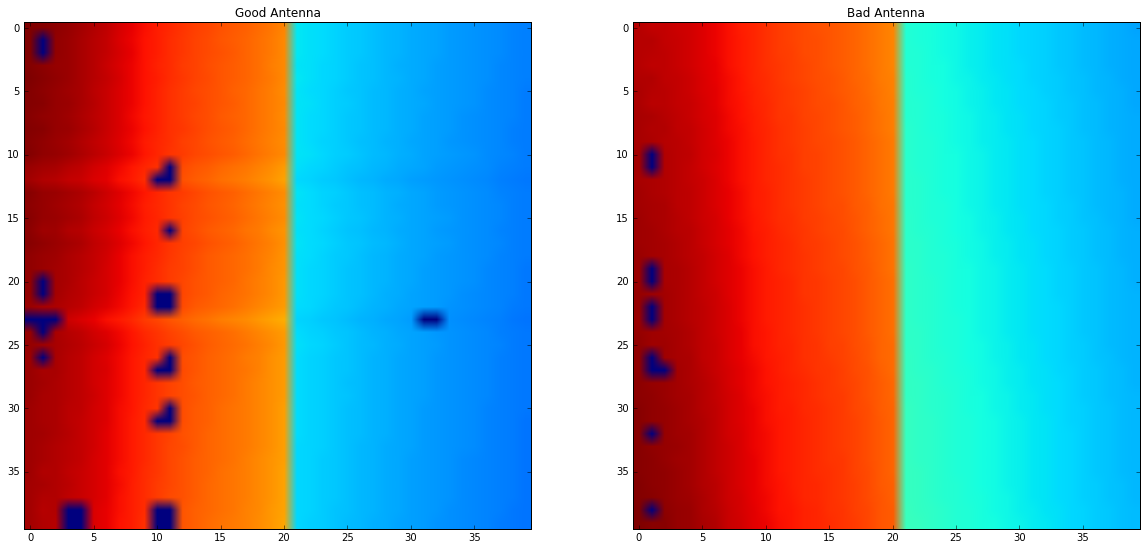

In [14]:
print X.dtype
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(X[0,0])
plt.title('Good Antenna')
plt.subplot(122)
plt.imshow(X[-1,0])
plt.title('Bad Antenna')

In [16]:
#Y2 = np.concatenate([np.ones(pos_samples2.shape[0]),np.ones(neg_samples2.shape[0])])
#X2 = np.concatenate([pos_samples2,neg_samples2])
#x2shape = X2.shape
#X2 = X2.reshape(x2shape[0],1,x2shape[1],x2shape[2])
##shuffle
#samps = np.arange(X2.shape[0])
#np.random.shuffle(samps)
#Xtest = X2[samps][:30000]
#ytest = Y2[samps][:30000]
#Xtrain = X[:len(samps)/3]; ytrain = Y[:len(samps)/3]
#Xtest = X[len(samps)/3:]; ytest = Y[len(samps)/3:]

In [15]:
print Xtrain.shape, ytrain.shape
print Xtest.shape,  ytest.shape

(121344, 1, 40, 40) (121344,)
(30336, 1, 40, 40) (30336,)


In [16]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command:
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
Note: the data was pickled with Python 2, and some encoding issues might prevent you
from loading it in Python 3. You might have to load it in Python 2,
save it in a different format, load it in Python 3 and repickle it.
'''

#from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 1024
nb_classes = 2
nb_epoch = 10
data_augmentation = False#True

# input image dimensions
img_rows, img_cols = 40, 40
# the CIFAR10 images are RGB
img_channels = 1

# the data, shuffled and split between train and test sets
print('Xtrain shape:', Xtrain.shape)
print(Xtrain.shape[0], 'train samples')
print(Xtest.shape[0], 'test samples')

# convert class vectors to binary class matrices
Ytrain = np_utils.to_categorical(ytrain, nb_classes)
Ytest = np_utils.to_categorical(ytest, nb_classes)

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Xtrain = Xtrain.astype('float32')
Xtest = Xtest.astype('float32')

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(Xtrain, Ytrain,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(Xtest, Ytest),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(Xtrain)

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(Xtrain, Ytrain,
                        batch_size=batch_size),
                        samples_per_epoch=Xtrain.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(Xtest, Ytest))

('Xtrain shape:', (121344, 1, 40, 40))
(121344, 'train samples')
(30336, 'test samples')
Not using data augmentation.
Train on 121344 samples, validate on 30336 samples
Epoch 1/10
121344/121344 [==============================] - 2517s - loss: 0.3998 - acc: 0.9702 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
  5120/121344 [>.............................] - ETA: 2171s - loss: 0.4061 - acc: 0.9748

Using Theano backend.


KeyboardInterrupt: 

In [ ]:
#look at samples that were classified incorrectly, and correctly, and plot them. 
# 

In [ ]:
#save the model.
#run on separate data.
